In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from astropy import constants as const
from astropy import units as u
from astropy.time import Time
from astropy.table import Table
from matplotlib.colors import LogNorm

import sys
sys.path.append('/Users/james/Dropbox/python/cubehelix/')
import cubehelix

In [3]:
# next steps... look at all alerts (via TNS?), and/or pull light curves for all 800 objects (ZTF?)

In [4]:
import ztfquery
ztfquery.ZTFQuery?

Init signature: ztfquery.ZTFQuery(metatable=None, kind=None)
File:           ~/anaconda3/lib/python3.11/site-packages/ztfquery/query.py
Type:           type
Subclasses:     

In [5]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [6]:
CMAP1 = cubehelix.cmap(start=0.5, rot=-0.6, sat=1.8, reverse=True)
CMAP2 = cubehelix.cmap(start=1.5, rot=-0.6, sat=1.8, reverse=True)

In [7]:
# SN 2023ixf Properties: https://www.wis-tns.org/object/2023ixf/discovery-cert
# distance from Cepheids: https://ned.ipac.caltech.edu/reflookup?refcode=2013ApJ...777...79M
d0 = 6.19 * u.Mpc

t0 = Time(2460084.2272569, format='jd')
c0 = SkyCoord(ra=210.91075*u.deg, dec=54.311694*u.deg, frame='icrs', distance=d0)

In [8]:
t0.datetime

datetime.datetime(2023, 5, 19, 17, 27, 14, 996174)

In [9]:
t0.mjd

60083.727256900165

In [10]:
# https://arxiv.org/abs/2012.02061
GCNS_file = '/Users/james/Dropbox/research_projects/lonely_stars/GCNS_cat.fits'
GCNS = Table.read(GCNS_file, format='fits')

# past me already did this, yay! 
# https://github.com/jradavenport/lonely_stars/blob/main/GCNS_KDTree.ipynb
c1 = SkyCoord(ra = GCNS['RA'] * u.degree,
              dec = GCNS['DEC'] * u.degree,
              distance= GCNS['DIST_50'] * u.kpc,
              frame='icrs')

len(GCNS)
# xyz = c1.transform_to(coord.Galactocentric)

331312

In [11]:
t1 = Time.now()# - (1 * u.day)
# t1 = Time({'year': 2023, 'month': 5, 'day': 30, 'hour':12}, format='ymdhms')
dt = t1-t0

# dt.sec
# dt.jd
dt.to('year')

<Quantity 1.11121322 yr>

In [12]:
int(t1.mjd)

60489

In [13]:
c = d0.to('lyr') / 2 # dist to foci from ellipse center
a = (((dt.to('s') * const.c) / 2) + c).to('lyr') # the semi-major axis of ellipse
print(a-c)

d1 = (GCNS['DIST_50'] * u.kpc) # dist to GCNS stars

d2 = c1.separation_3d(c0)

0.5556066110730171 lyr


In [14]:
# A few things to compute for each GCNS object:

# 1. has it seen SN  yet?
SNYES = d2.to('lyr').value <= (d0.to('lyr') + (dt.to('s') * const.c)).to('lyr').value
SNNO = ~SNYES

# 2. is it within the "SETI ellipse"?
EYES = (d1.to('lyr').value + d2.to('lyr').value) <= (2 * a.to('lyr').value)
ENO = ~EYES

# 3. is it within some tolerance of being ON the ellipse?
#    this could be within some range in distance or in time, thanks to speed of light...
tol = 0.1 # in lyr
OYES = np.abs((d1.to('lyr').value + d2.to('lyr').value) - (2 * a.to('lyr').value)) <= tol

In [15]:
print(len(d1))
print(sum(SNYES), sum(SNNO))
print('inside ellipsoid:', sum(EYES))
print('within tol of surface:', sum(OYES))
# print(sum(SNYES) / (sum(SNYES) + sum(SNNO)))
# print(sum(SNNO) / (sum(SNYES) + sum(SNNO)))
# print(sum(EYES) / (sum(SNYES) + sum(SNNO)))

331312
165453 165859
inside ellipsoid: 862
within tol of surface: 147


In [19]:
sum(OYES + EYES)

931

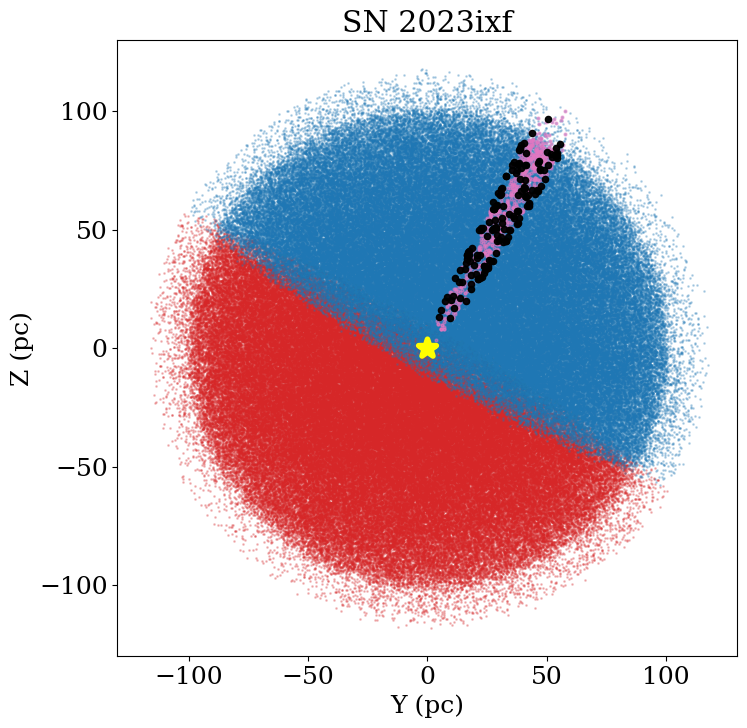

In [14]:
plt.figure(figsize=(8,8))
plt.scatter(GCNS['YCOORD_50'][SNNO], GCNS['ZCOORD_50'][SNNO], c='C3', s=1, alpha=0.25, rasterized=True)
plt.scatter(GCNS['YCOORD_50'][SNYES],GCNS['ZCOORD_50'][SNYES], c='C0', s=1, alpha=0.25, rasterized=True)
plt.scatter(GCNS['YCOORD_50'][EYES], GCNS['ZCOORD_50'][EYES], c='C6', s=4, alpha=0.5, rasterized=True)
plt.scatter(GCNS['YCOORD_50'][OYES], GCNS['ZCOORD_50'][OYES], c='k', s=20, alpha=0.95, rasterized=True)

plt.scatter([0],[0], c='yellow', marker='*', s=180, lw=4)
plt.title('SN 2023ixf')
plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')
# plt.grid(True)
plt.xlim(-130,130)
plt.ylim(-130,130)
plt.savefig('SN2023ixf'+str(int(t1.mjd))+'.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

Text(0, 0.5, '$M_G$ (mag)')

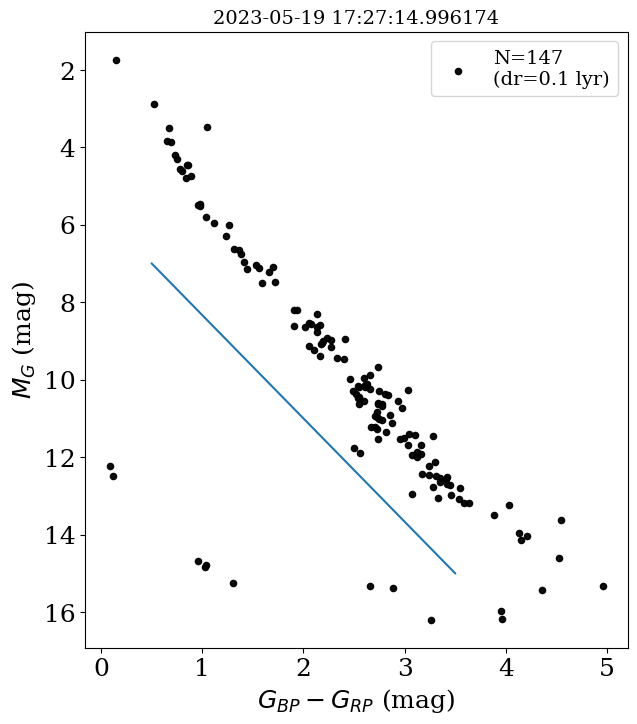

In [15]:
plt.figure(figsize=(7,8))

# plt.scatter(GCNS['PHOT_BP_MEAN_MAG'][SNNO] - GCNS['PHOT_RP_MEAN_MAG'][SNNO],
#             GCNS['PHOT_G_MEAN_MAG'][SNNO] - 5.*np.log10(GCNS['DIST_50'][SNNO]*1000)+5, 
#             c='C3', s=1, alpha=0.25, rasterized=True)
# plt.scatter(GCNS['PHOT_BP_MEAN_MAG'][SNYES] - GCNS['PHOT_RP_MEAN_MAG'][SNYES],
#             GCNS['PHOT_G_MEAN_MAG'][SNYES] - 5.*np.log10(GCNS['DIST_50'][SNYES]*1000)+5, 
#             c='C0', s=1, alpha=0.25, rasterized=True)

# plt.scatter(GCNS['PHOT_BP_MEAN_MAG'][EYES] - GCNS['PHOT_RP_MEAN_MAG'][EYES],
#             GCNS['PHOT_G_MEAN_MAG'][EYES] - 5.*np.log10(GCNS['DIST_50'][EYES]*1000)+5, 
#             c='C6', s=4, alpha=0.5, rasterized=True)

plt.scatter(GCNS['PHOT_BP_MEAN_MAG'][OYES] - GCNS['PHOT_RP_MEAN_MAG'][OYES],
            GCNS['PHOT_G_MEAN_MAG'][OYES] - 5.*np.log10(GCNS['DIST_50'][OYES]*1000)+5, 
            c='k', s=20, alpha=0.95, rasterized=True, label='N='+str(sum(OYES))+'\n(dr=0.1 lyr)')

# yerr = 
# xerr = GCNS['']

# plt.scatter(GCNS['YCOORD_50'][SNYES],GCNS['ZCOORD_50'][SNYES], c='C0', s=1, alpha=0.25, rasterized=True)
# plt.scatter(GCNS['YCOORD_50'][EYES], GCNS['ZCOORD_50'][EYES], c='C6', s=4, alpha=0.5, rasterized=True)
# plt.scatter(GCNS['YCOORD_50'][OYES], GCNS['ZCOORD_50'][OYES], c='k', s=20, alpha=0.95, rasterized=True)

plt.gca().invert_yaxis()
plt.title(str(t0.datetime), fontsize=14)
plt.plot([0.5, 3.5], [7, 15])
plt.legend(fontsize=14)

plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')
# plt.xlim(-130,130)
# plt.ylim(-130,130)
# plt.savefig('SN2023ixf_CMD_on.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

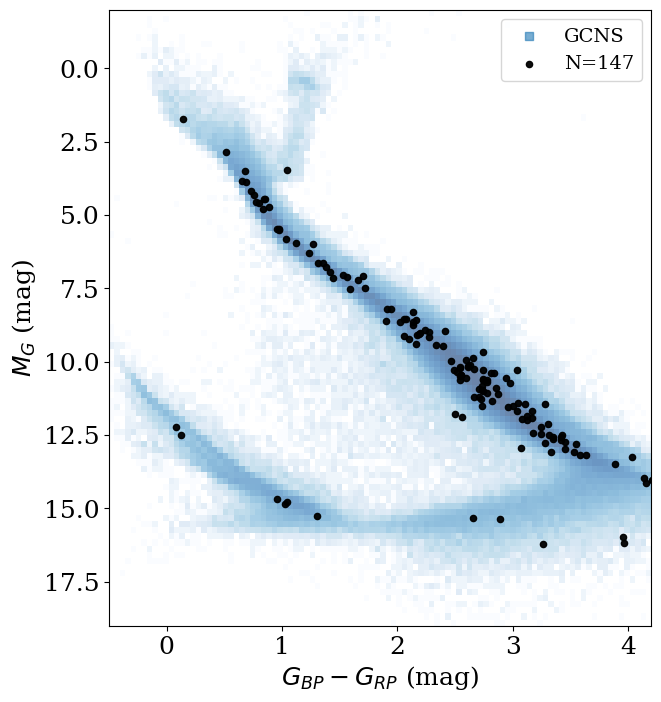

In [16]:
plt.figure(figsize=(7,8))

_ = plt.hist2d(GCNS['PHOT_BP_MEAN_MAG'] - GCNS['PHOT_RP_MEAN_MAG'],
            GCNS['PHOT_G_MEAN_MAG'] - 5.*np.log10(GCNS['DIST_50']*1000)+5, 
               bins=100, range=[[-0.5,4.2],[-2,19]], cmap=plt.cm.Blues, norm=LogNorm(), alpha=0.6)

plt.scatter([],[], c='C0', marker='s', label='GCNS', alpha=0.6)


plt.scatter(GCNS['PHOT_BP_MEAN_MAG'][OYES] - GCNS['PHOT_RP_MEAN_MAG'][OYES],
            GCNS['PHOT_G_MEAN_MAG'][OYES] - 5.*np.log10(GCNS['DIST_50'][OYES]*1000)+5, 
            c='k', s=20, alpha=0.95, rasterized=True, label='N='+str(sum(OYES)))


plt.gca().invert_yaxis()
# plt.title(str(t0.datetime), fontsize=14)

plt.legend(fontsize=14)

plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')
# plt.xlim(-130,130)
# plt.ylim(-130,130)
plt.savefig('SN2023ixf_CMD'+str(int(t1.mjd))+'.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

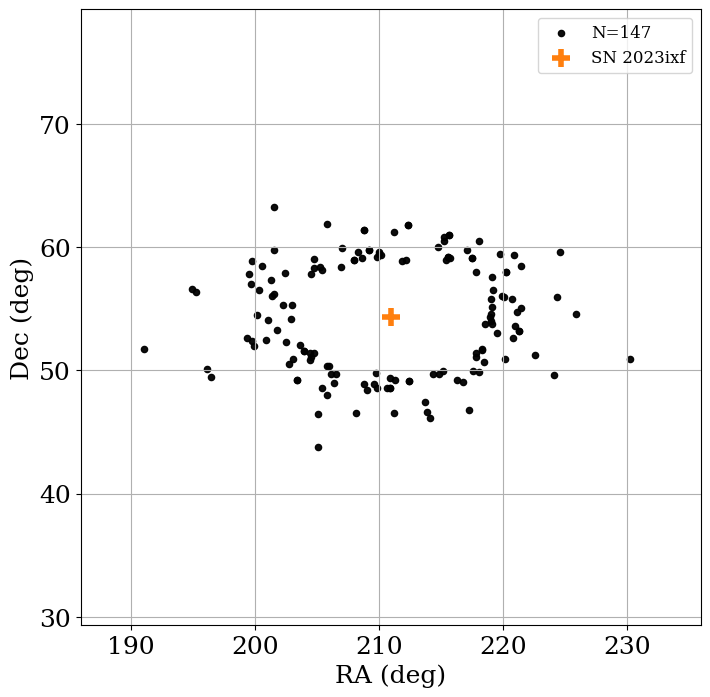

In [18]:
plt.figure(figsize=(8,8))
plt.scatter(GCNS['RA'][OYES], GCNS['DEC'][OYES],c='k', s=20, alpha=0.95, 
            label='N='+str(sum(OYES)))#+'\n(dr=0.1 lyr)' )
plt.scatter(c0.ra, c0.dec, c='C1', marker='+', s=180,  lw=4, label='SN 2023ixf')
plt.legend(fontsize=12)
plt.grid(True)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
da = 25
plt.xlim(c0.ra.value-da,c0.ra.value+da)
plt.ylim(c0.dec.value-da, c0.dec.value+da)
# plt.title(str(t0.datetime), fontsize=14)
plt.savefig('SN2023ixf_radec'+str(int(t1.mjd))+'.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [22]:
# make a watchmap for Lasair using the current extent
# from mocpy import MOC, WCS
dfout = pd.DataFrame(data={'ra':GCNS['RA'][OYES+EYES], 
                           'dec':GCNS['DEC'][OYES+EYES],
                           'id':GCNS['SOURCE_ID'][OYES+EYES], 
                           'radius':np.ones(sum(OYES+EYES)) * 1.5}) # 1.5 arcsecond radius
dfout.to_csv('watchlist_thru_'+str(int(t1.mjd))+'.csv',index=False,index_label=False)

In [23]:
len(dfout)

931

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        27,  28,  30,  31,  32,  33,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        84,  85,  86,  87,  88,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146])

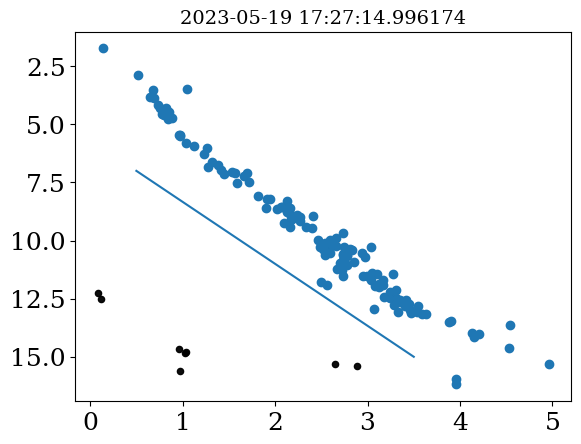

In [25]:
mm = (15-7)/(3.5-.5)
bb = 15 - (mm *3.5)

star = np.where((GCNS['PHOT_G_MEAN_MAG'][OYES] - 5.*np.log10(GCNS['DIST_50'][OYES]*1000)+5) < ( bb + (GCNS['PHOT_BP_MEAN_MAG'][OYES] - GCNS['PHOT_RP_MEAN_MAG'][OYES])*mm ))[0]

plt.scatter(GCNS['PHOT_BP_MEAN_MAG'][OYES] - GCNS['PHOT_RP_MEAN_MAG'][OYES],
            GCNS['PHOT_G_MEAN_MAG'][OYES] - 5.*np.log10(GCNS['DIST_50'][OYES]*1000)+5, 
            c='k', s=20, alpha=0.95, rasterized=True)
plt.scatter(GCNS['PHOT_BP_MEAN_MAG'][OYES][star] - GCNS['PHOT_RP_MEAN_MAG'][OYES][star],
            GCNS['PHOT_G_MEAN_MAG'][OYES][star] - 5.*np.log10(GCNS['DIST_50'][OYES][star]*1000)+5)

# yerr = 
# xerr = GCNS['']

# plt.scatter(GCNS['YCOORD_50'][SNYES],GCNS['ZCOORD_50'][SNYES], c='C0', s=1, alpha=0.25, rasterized=True)
# plt.scatter(GCNS['YCOORD_50'][EYES], GCNS['ZCOORD_50'][EYES], c='C6', s=4, alpha=0.5, rasterized=True)
# plt.scatter(GCNS['YCOORD_50'][OYES], GCNS['ZCOORD_50'][OYES], c='k', s=20, alpha=0.95, rasterized=True)

plt.gca().invert_yaxis()
plt.title(str(t0.datetime), fontsize=14)
plt.plot([0.5, 3.5], [7, 15])

star

In [26]:
# etime = d2.to('lyr') + d1.to('lyr') - (2*c)
etime = (d2.to('lyr') + d1.to('lyr') - (2*c)).value + t0.decimalyear
etime

array([2424.80391403, 2235.92414713, 2149.14293198, ..., 2374.71864929,
       2216.45163749, 2553.60099885])

In [27]:
stars = np.zeros(sum(OYES),dtype=int)
stars[star] = 1
df_out = pd.DataFrame(data={'ra':GCNS['RA'][OYES], 'dec':GCNS['DEC'][OYES], 
                            'd(pc)':GCNS['DIST_50'][OYES]*1000, 
                            'bp_rp': GCNS['PHOT_BP_MEAN_MAG'][OYES] - GCNS['PHOT_RP_MEAN_MAG'][OYES],
                            'M_G':GCNS['PHOT_G_MEAN_MAG'][OYES] - 5.*np.log10(GCNS['DIST_50'][OYES]*1000)+5,
                            'crossMJD':Time(etime[OYES], format='decimalyear').mjd, 
                            'pmra':GCNS['PMRA'][OYES],
                            'pmdec':GCNS['PMDEC'][OYES],
                            'parallax':GCNS['PARALLAX'][OYES],
                            'rv':GCNS['ADOPTEDRV'][OYES],
                            'star':stars,
                            'source_id':GCNS['SOURCE_ID'][OYES]})
df_out
df_out.to_csv('SN2023ixf_'+str(int(t1.mjd))+'.csv')

In [28]:
# # a different output file for Sofia
# df_out2 = pd.DataFrame(data={'ra':GCNS['RA'][OYES],
# 'dec':GCNS['DEC'][OYES],
# 'pmra':GCNS['PMRA'][OYES],
# 'pmdec':GCNS['PMDEC'][OYES],
# 'parallax':GCNS['PARALLAX'][OYES],
# 'rv':GCNS['ADOPTEDRV'][OYES],'source_id':GCNS['SOURCE_ID'][OYES]})
# df_out2.to_csv('SN2023ixf_'+str(int(t1.mjd))+'_v2.csv')

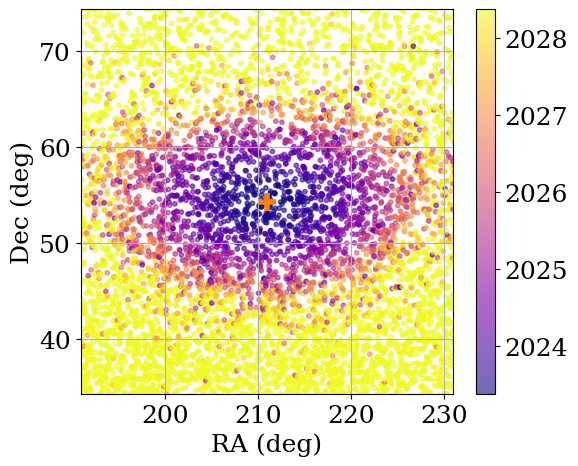

In [29]:
plt.figure(figsize=(6,5))
plt.scatter(GCNS['RA'], GCNS['DEC'], c=etime, s=10, alpha=0.6, cmap=plt.cm.plasma )
plt.clim(t0.decimalyear, t0.decimalyear + 5)
cb = plt.colorbar()

plt.scatter(c0.ra, c0.dec, c='C1', marker='+', s=180,  lw=4)
plt.grid(True)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
da = 20
plt.xlim(c0.ra.value-da,c0.ra.value+da)
plt.ylim(c0.dec.value-da, c0.dec.value+da)
plt.savefig('SN2023ixf_radec_time.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [103]:
alert1 = pd.read_csv('SN2023ixf_60489_watchlist_results.csv')
filter = pd.read_csv('lasair_1083SN2023ixf_ellipsoid_objects_v2_filter_results.csv')
print(len(alert1), len(filter))

269 69


In [ ]:
ztf_id = 'ZTF23aaklqou' # this is the ZTF alert name for SN2023ixf

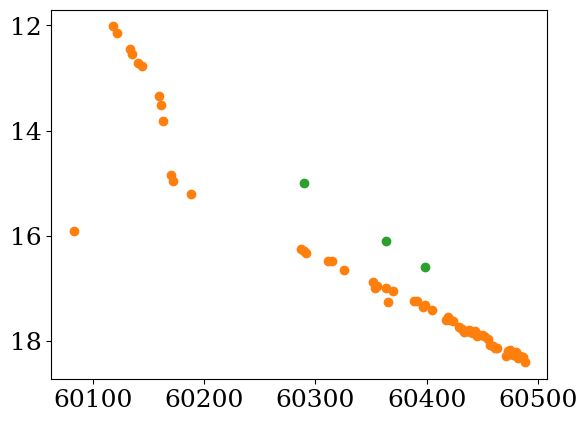

In [85]:
from alerce.core import Alerce
alerce = Alerce()

SN_LC = alerce.query_lightcurve("ZTF23aaklqou", format="json")

for k in range(len(SN_LC['detections'])):
    plt.scatter(SN_LC['detections'][k]['mjd'], SN_LC['detections'][k]['magpsf'], 
                c='C'+str(SN_LC['detections'][k]['fid']))
plt.gca().invert_yaxis()

In [114]:
# lets compare the predicted crossing times for these stars to their alert times
GCNSdf = GCNS.to_pandas()
GCNSdf['etime'] = etime
objs = pd.merge(GCNSdf, filter, left_on='SOURCE_ID', right_on='name')

In [125]:
# Min Alert Time - Predicted Ellipsoid Crossing Time [days]
objs['jdmin'].values - Time(objs['etime'].values, format='decimalyear').jd

array([ -88.33325547, -285.32301709,  100.20621558,   88.73480807,
       -413.35377333, -327.61985533, -351.89725283, -239.58532439,
        100.77463123,  184.83752368,   19.12336384,  180.44708839,
       -215.75229717, -270.36324753,  -79.10984084,  -78.37958102,
        247.04099309,  -82.64243024,   44.51429804, -157.51700789,
       -105.21072675,  -16.93531487, -176.68232877,  -95.10896418,
        133.24343661,  217.94828062,  -49.28712596,  287.6427576 ,
         85.16237773,  187.83248932,   51.48415319, -203.72180741,
         51.48415319,  227.27159539,   51.76251407,  -88.14142135,
       -399.92542726, -250.41070284,  309.37622904, -318.34507679,
        247.99348173,  213.66638615, -174.58305471,  156.44860951,
       -125.86790054, -313.8427256 , -249.82660662, -186.47008769,
          9.47769909, -251.42283845, -325.09619276,  -39.01291968,
        120.50441854,  -43.20624116,  128.77263664, -132.37898942,
       -132.25399207, -410.24312211, -410.24312211,  168.30762

In [131]:
huhlimit = 60 # how many days within Ellipsoid is interesting?
huh = abs(objs['jdmin'].values - Time(objs['etime'].values, format='decimalyear').jd) < huhlimit
sum(huh)

13

In [132]:
filter['objectId'][huh]

10    ZTF21aagdkfa
18    ZTF18adqgatn
21    ZTF18adizeie
26    ZTF18aaxmtcj
30    ZTF18aascsxu
32    ZTF18aarfrhh
34    ZTF18aarfhjg
48    ZTF18aamvxqc
51    ZTF18aamuklv
53    ZTF18aakrdwo
61    ZTF18aajockf
66    ZTF18aahwkyr
67    ZTF18aagzuxp
Name: objectId, dtype: object

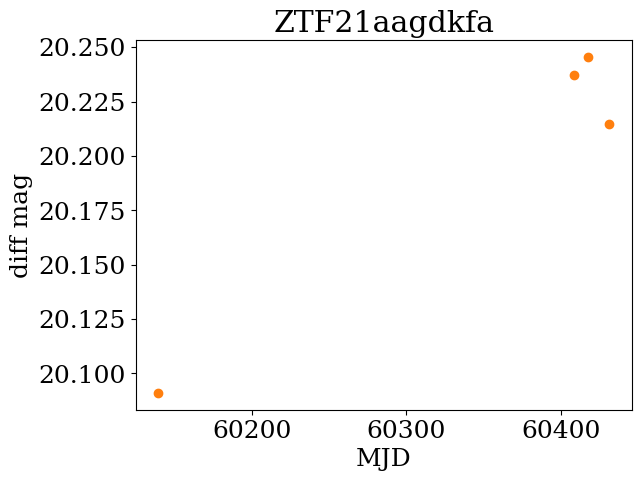

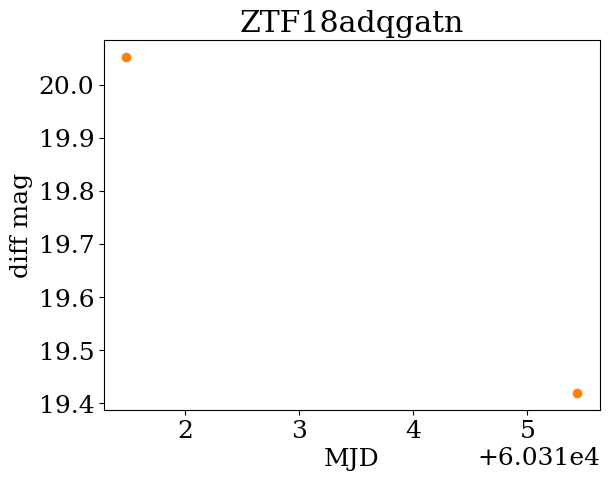

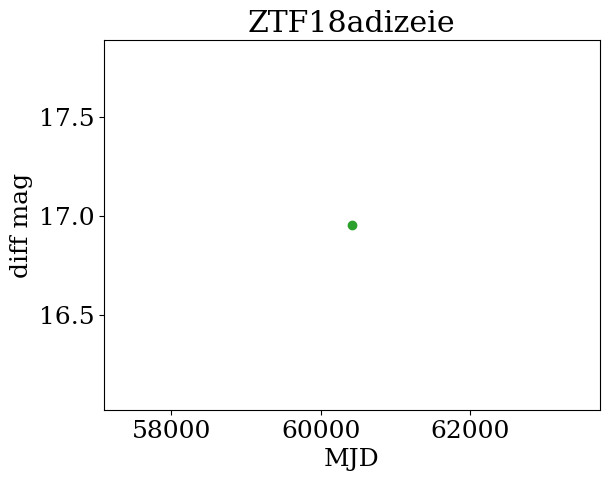

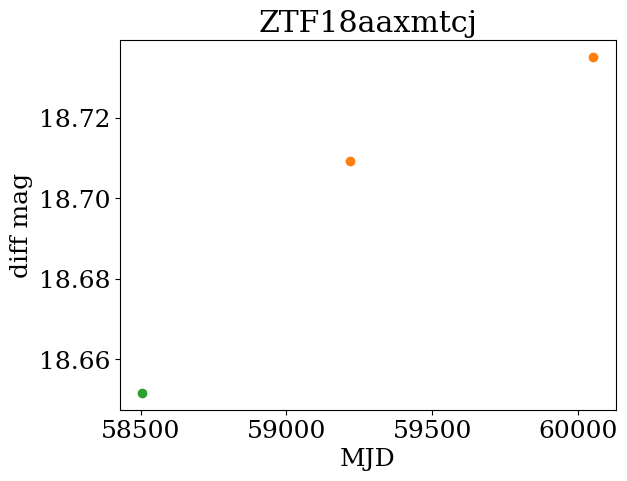

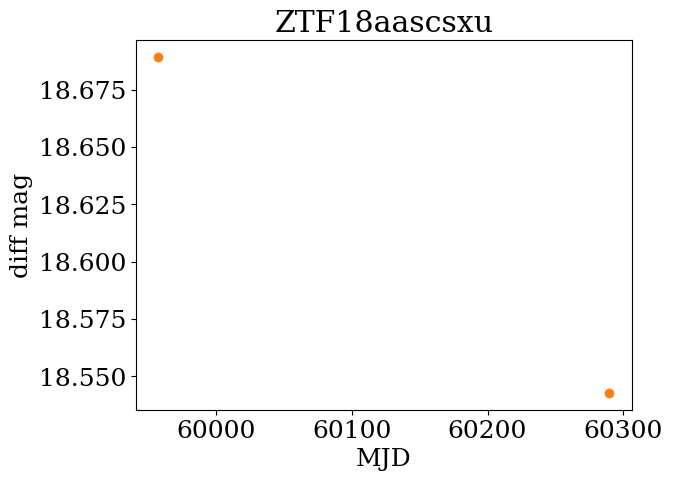

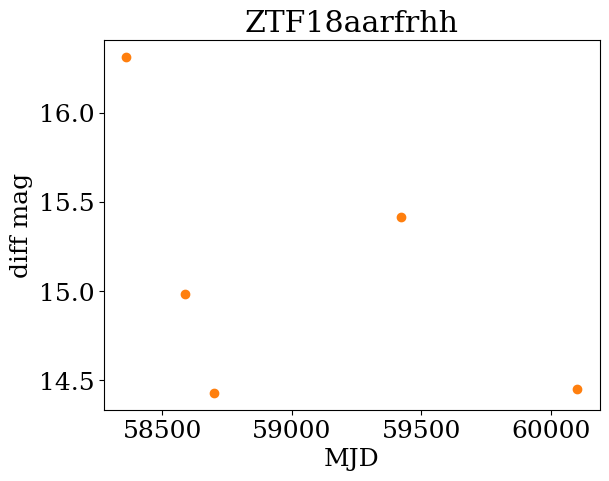

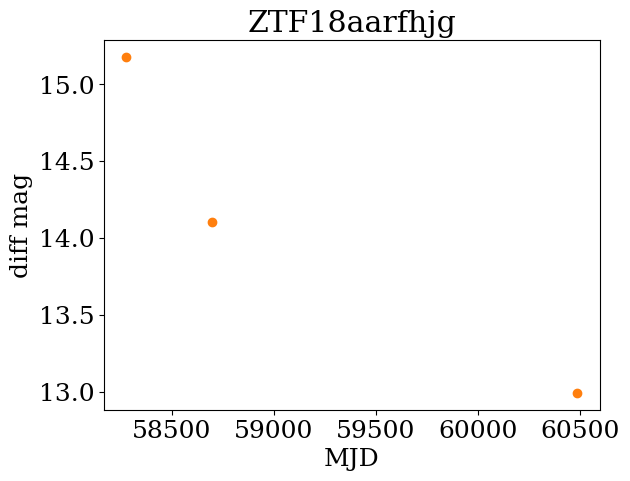

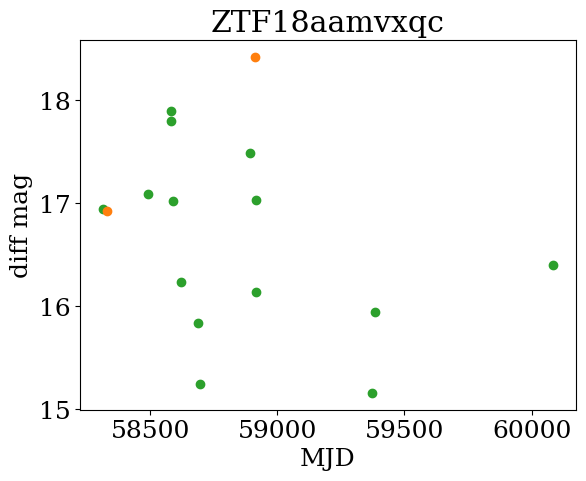

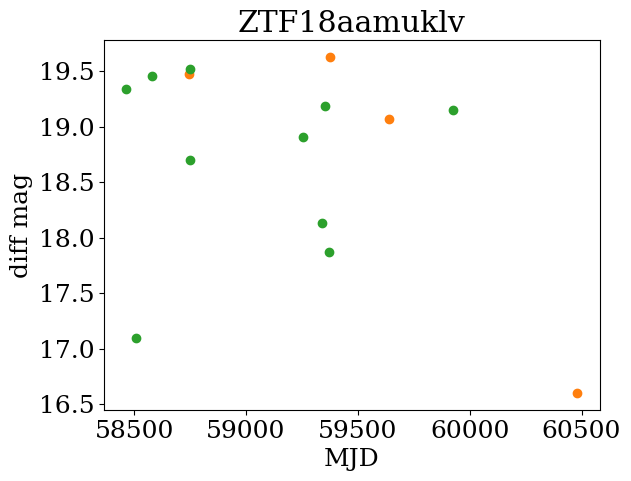

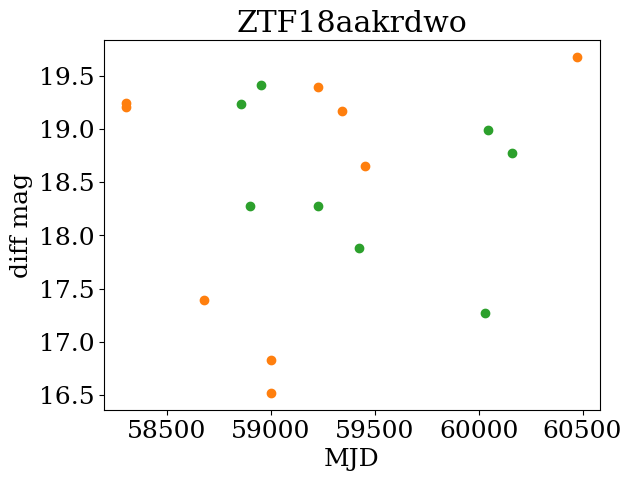

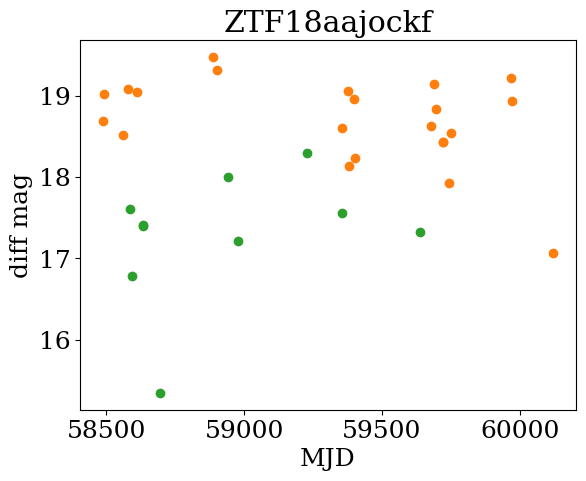

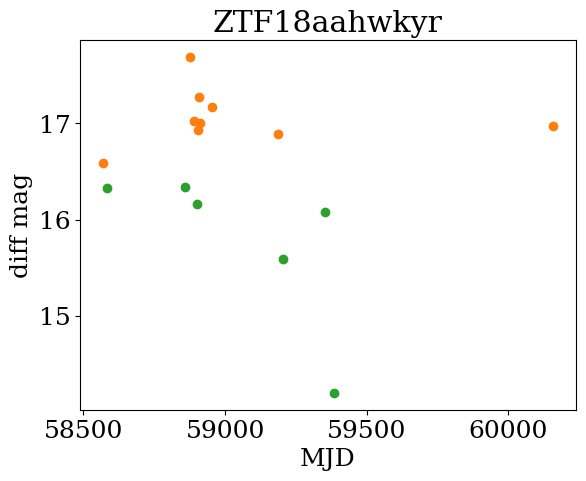

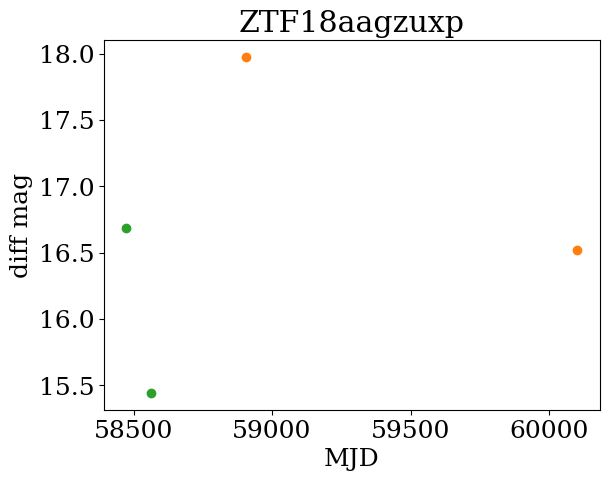

In [134]:
for j in range(sum(huh)):
    LC = alerce.query_lightcurve(filter['objectId'][huh].values[j], format="json")
    
    plt.figure()
    for k in range(len(LC['detections'])):
        plt.scatter(LC['detections'][k]['mjd'], LC['detections'][k]['magpsf'], 
                    c='C'+str(LC['detections'][k]['fid']))
    # plt.gca().invert_yaxis()
    plt.title(filter['objectId'][huh].values[j])
    plt.xlabel('MJD')
    plt.ylabel('diff mag')
    plt.show()

In [20]:

for k in range(10):
    tok = np.where((etime > (2023+k)) & (etime <= (2023+(k+1))))[0]
    msep = np.nanmedian(c1[tok].separation(c0).value)
    print(2023+k, msep)


2023 3.0512908890656942
2024 5.7138880141037784
2025 7.6181284507837495
2026 9.40172637986154
2027 10.6473278546593
2028 12.032432924114433
2029 13.12725680730248
2030 14.185884539166615
2031 15.426500918383164
2032 16.276671928321335


In [21]:
dda = np.where((np.sqrt((GCNS['RA'].value - c0.ra.value)**2 + (GCNS['DEC'].value - c0.dec.value)**2) < da))[0]


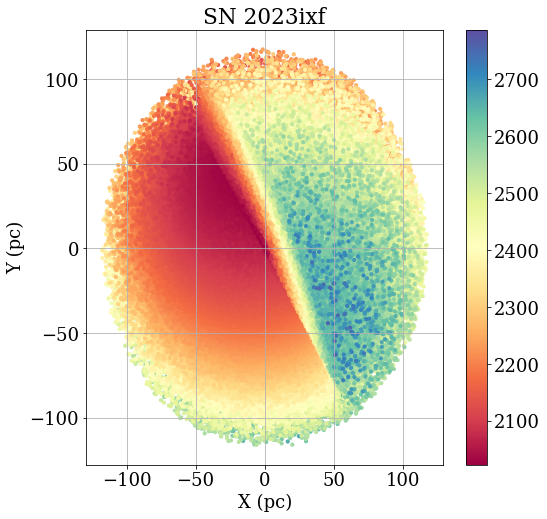

In [22]:
plt.figure(figsize=(8,8))
plt.scatter(GCNS['XCOORD_50'], GCNS['YCOORD_50'], c=etime, s=10, cmap=plt.cm.Spectral)
# plt.xlim(-10,10)
# plt.ylim(-10,10)
# plt.clim(2023,2080)
cb = plt.colorbar()

plt.title('SN 2023ixf')
plt.xlabel('X (pc)')
plt.ylabel('Y (pc)')
plt.grid(True)

(2021.0, 2222.0)

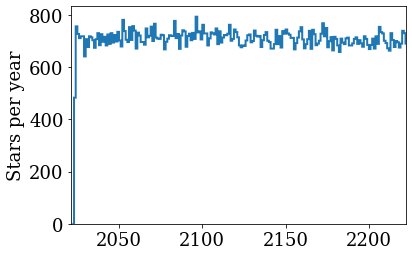

In [23]:
_ = plt.hist(etime, bins=np.arange(2022,2600), histtype='step', lw=2)
plt.ylabel('Stars per year')
plt.xlim(2021,2222)

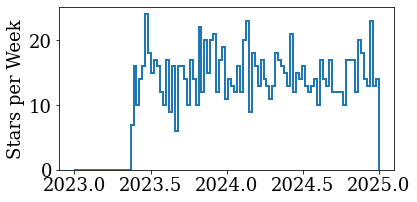

In [24]:
plt.figure(figsize=(6,3))
_ = plt.hist(etime,bins=np.linspace(2023,2025,104), histtype='step', lw=2)
plt.ylabel('Stars per Week')
plt.savefig('SN2023ixf_time2.png', dpi=150, bbox_inches='tight', pad_inches=0.25)